In [1]:
import numpy as np
from audlib.sig.window import hamming, rect
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
from numpy.fft import fft, rfft, ifft
from audlib.sig.fbanks import LinFreq, MelFreq
plt.rc('text', usetex=True)

Text(0.5,1,'100-point Hamming window')

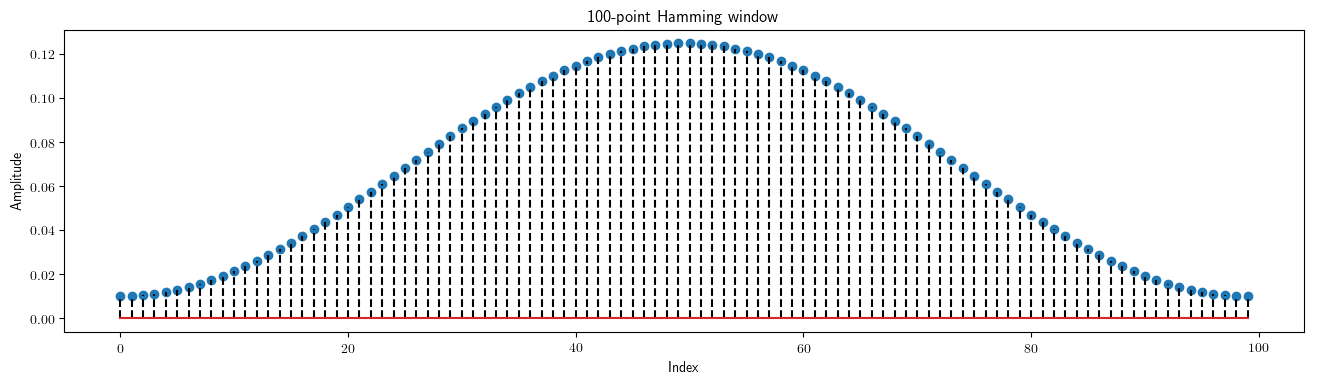

In [2]:
## Creating a Hamming window
sr = 16000
window_length = 0.010  # in seconds
hop_fraction = 0.25
wsize = 100
wind = hamming(wsize, nchan=wsize)
#wind = rect(wsize, normdc=True)
fig = plt.figure(figsize=(16, 4), dpi= 100)
ax = fig.add_subplot(111)
ax.stem(np.arange(wsize),wind, linefmt='--k')
ax.set_xlabel('Index'); ax.set_ylabel('Amplitude'); ax.set_title('{}-point Hamming window'.format(wsize))

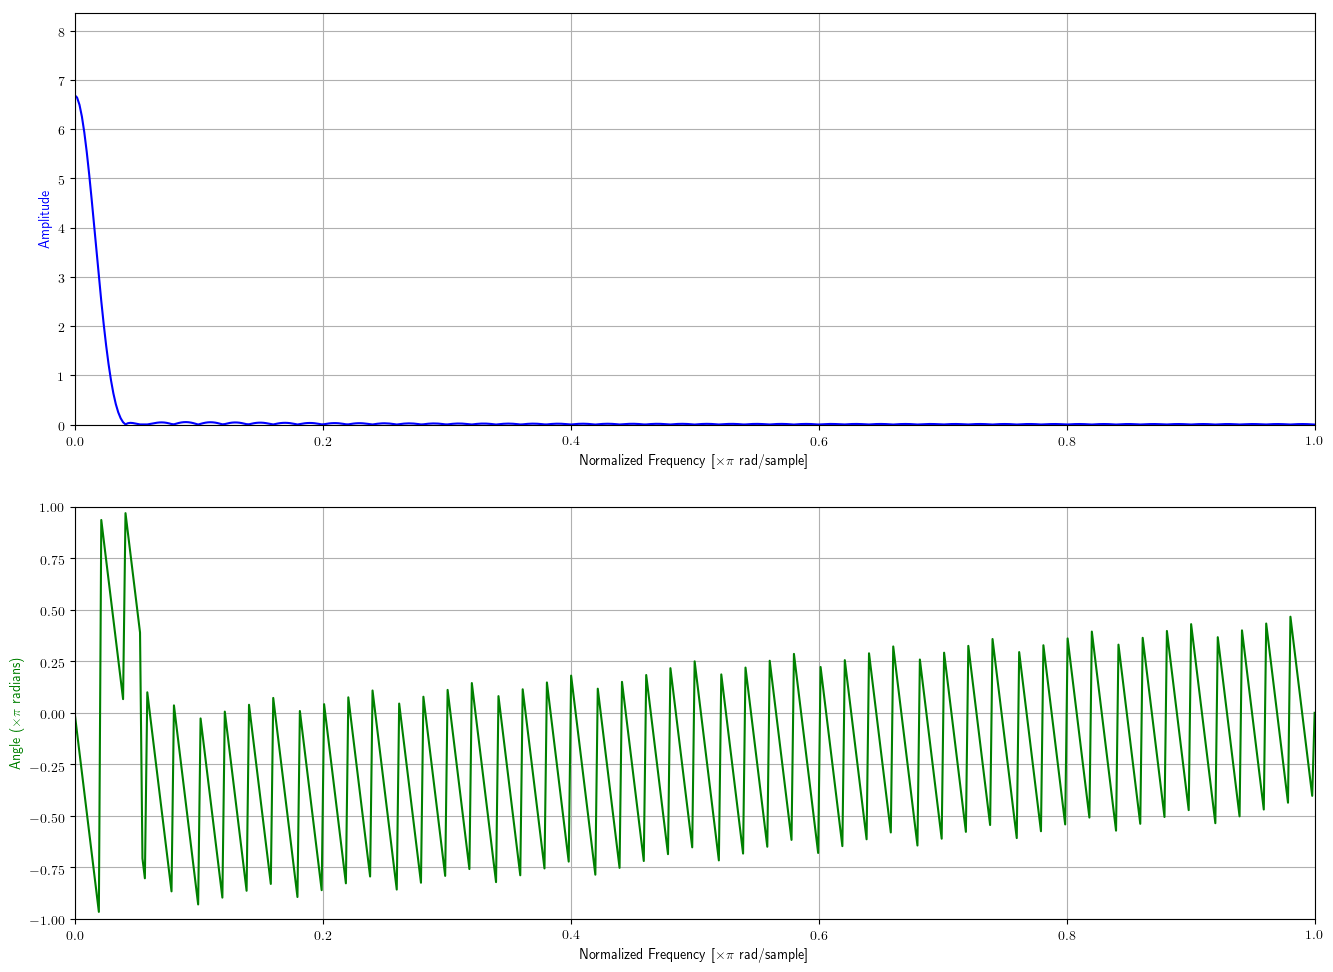

In [3]:
from audlib.plot import magresp, phsresp

## Plot Hamming window's frequency response
nfft = max(1024, int(2**np.ceil(np.log2(wsize))))  # at least show 512 frequency points
#ww, hh = signal.freqz(wind, whole=True, worN=)
ww = np.linspace(0, 2, num=nfft, endpoint=False)[:(nfft//2+1)]
hh = rfft(wind, n=nfft)
#import ipdb; ipdb.set_trace()
fig = plt.figure(figsize=(16, 12), dpi= 100)
ax1 = fig.add_subplot(211)
magresp(ww, hh, ax1, units=('rad', 'mag'))
# Plot phase response
ax2 = fig.add_subplot(212)
angles = np.angle(hh)
phsresp(ww, hh, ax2)

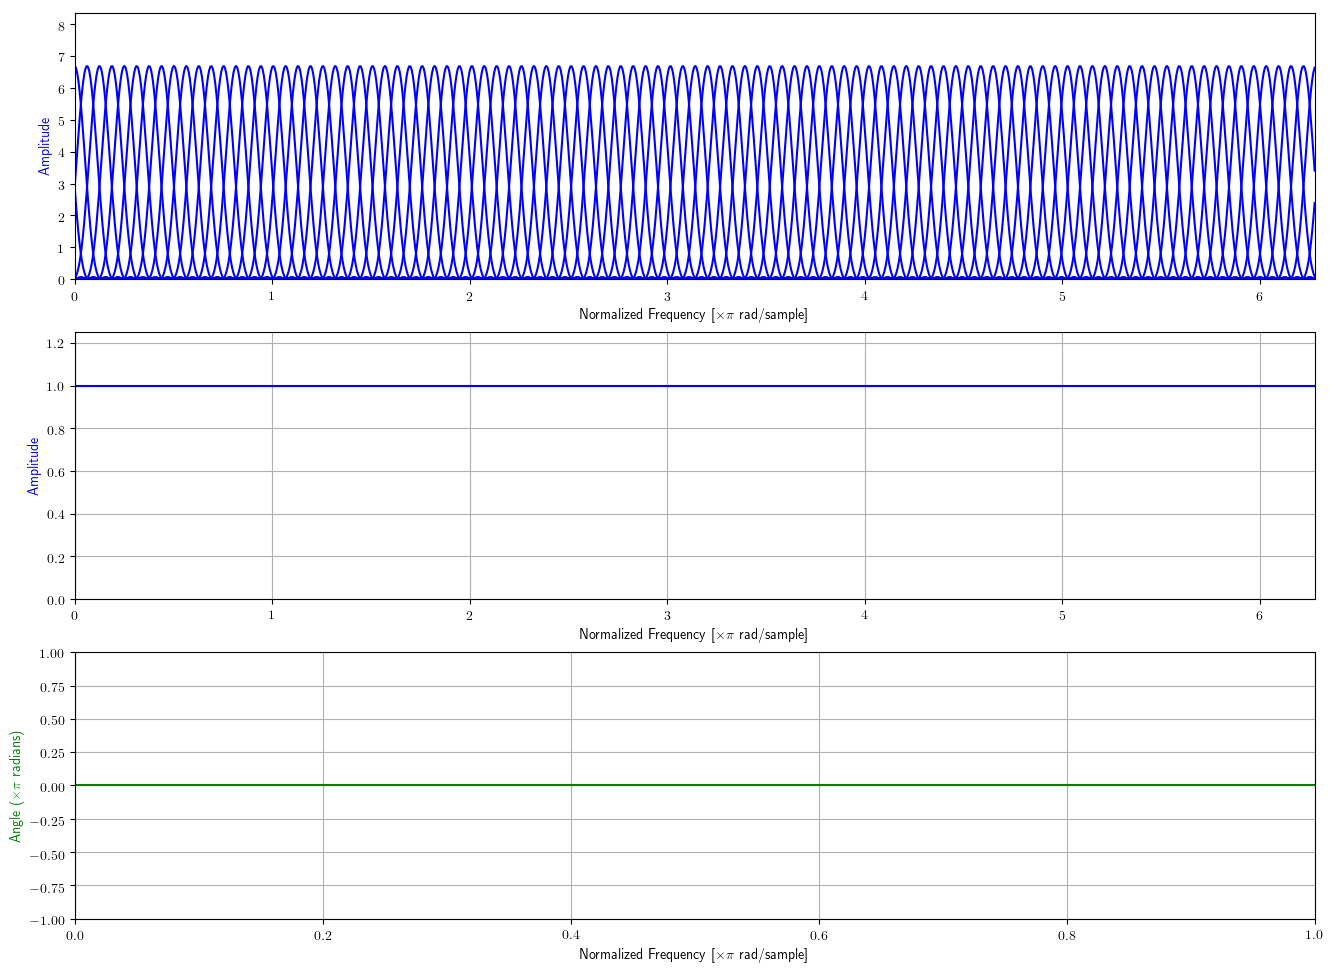

In [4]:
## Make a filterbank out of a prototype lowpass filter
fbank = LinFreq(wind)
resp = np.zeros(1024, dtype=np.complex_)

### Plot first few filter responses
fig = plt.figure(figsize=(16, 12), dpi= 100)
ax1 = fig.add_subplot(311)
for kk in range(len(fbank)):
    #import pdb; pdb.set_trace()
    ww, hh = fbank.freqz(kk)
    magresp(ww, hh, ax1, units=('rad', 'mag'))
    resp += hh
ax2 = fig.add_subplot(312)
magresp(ww, resp, ax2, units=('rad', 'mag'))
ax3 = fig.add_subplot(313)
phsresp(ww, resp, ax3)

Mean squared error: [1.0157552978123277e-28]


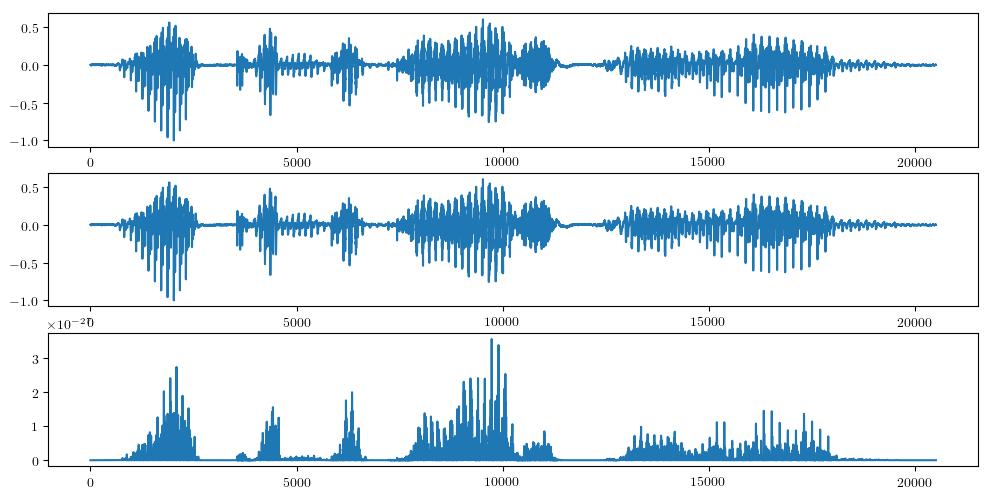

In [5]:
# Filter sample audio with the filterbank
from audlib.io.audio import audioread
sig, sr = audioread('../../samples/welcome16k.wav')
sigfilt = np.zeros((len(fbank), len(sig)), dtype=np.complex_)  # no decimation for now
for kk in range(len(fbank)):
    sigfilt[kk, :] = fbank.filter(sig, kk)

# Reconstruction
sigout = np.zeros_like(sig, dtype=np.complex_)
for kk in range(len(fbank)):
    mod = np.exp(1j*(2*np.pi*kk/len(fbank))*np.arange(len(sig)))
    sigout += (sigfilt[kk, :]*mod)
sigout = np.real(sigout)
mse =np.mean((sigout-sig)**2)
print("Mean squared error: [{}]".format(mse))
fig = plt.figure(figsize=(12, 6), dpi= 100)
ax = fig.add_subplot(311)
ax.plot(sig)
ax = fig.add_subplot(312)
ax.plot(sigout)
ax = fig.add_subplot(313)
ax.plot((sigout-sig)**2)

In [6]:
# Play original audio
import IPython.display as ipd
ipd.Audio(sig, rate=sr)

In [10]:
# Followed by the reconstructed audio after FBS
ipd.Audio(sigout, rate=sr)

In [ ]:
# TODO: Filterbank with decimation